<a href="https://colab.research.google.com/github/ramya-njn/Transformers-BERT-Fine-Tuning/blob/main/Transfer_Learning_using_HuggingFace_TrainerAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Dataset** : https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences, reviews data from amazon.com
### **General Workflow**:
### 1. Convert pandas dataframe into a Hugging Face Dataset
### 2. Tokenize text, load a pretrained model, set training arguments, and train a transfer learning model
### 3. Make predictions and evaluate the model performance of a fine-tuned transfer learning model for text classification
### 4. Save and reload the model

# 1. Install and Import required Libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate

In [ ]:
!pip install accelerate -U

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback

from datasets import Dataset

import evaluate

# 2. Import and Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive/Fine_Tuning_Transformer')

In [ ]:
os.getcwd()

'/content/drive/My Drive/Fine_Tuning_Transformer'

In [ ]:
data = pd.read_csv('amazon_cells_labelled.txt', sep = '\t', names = ['review', 'label'])
data.head()

,review,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [ ]:
data.shape

(1000, 2)

In [ ]:
data.isna().apply(pd.value_counts)

,review,label
False,1000,1000


In [ ]:
data['label'].value_counts()

label
0    500
1    500
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

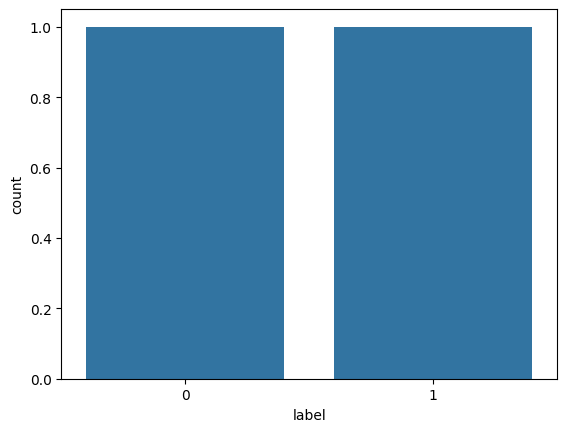

In [ ]:
sns.countplot(data['label'].value_counts())

# 3. Train Test Split

In [ ]:
train_df = data.sample(frac=0.8, random_state = 42)
test_df = data.drop(train_df.index)

print('Train Data:', train_df.shape)
print('Test Data:', test_df.shape)

Train Data: (800, 2)
Test Data: (200, 2)


# 4. Convert data from Pandas to HuggingFace Dataset


In [ ]:
train_hf =  Dataset.from_pandas(train_df)
test_hf =  Dataset.from_pandas(test_df)

print(train_hf, '\n')
print(train_hf[0], '\n')
print(test_hf)

Dataset({
    features: ['review', 'label', '__index_level_0__'],
    num_rows: 800
}) 

{'review': 'Thanks again to Amazon for having the things I need for a good price!', 'label': 1, '__index_level_0__': 521} 

Dataset({
    features: ['review', 'label', '__index_level_0__'],
    num_rows: 200
})


# 5. Load Tokenizer and Pre-trained Model

In [ ]:
model_version = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained (model_version)
model = AutoModelForSequenceClassification.from_pretrained (model_version)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# 6. Tokenize dataset using Hugging Face Batch Mapping

In [ ]:
def tokenize(batch):
  return tokenizer(batch['review'], padding = True, truncation = True)

# tokenize the first two samples from train data
tokenize(train_hf[:2])

{'input_ids': [[101, 4283, 2153, 2000, 9733, 2005, 2383, 1996, 2477, 1045, 2342, 2005, 1037, 2204, 3976, 999, 102, 0, 0, 0, 0, 0, 0], [101, 1996, 19817, 6305, 14876, 2638, 8545, 5910, 4221, 2003, 5310, 5379, 1998, 3084, 2009, 3733, 2000, 18908, 21466, 1010, 4385, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
train_encoded = train_hf.map(tokenize, batched = True, batch_size = None)
test_encoded =  test_hf.map(tokenize, batched = True, batch_size = None)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
print(train_encoded, '\n')
print(len(train_encoded), '\n')
print(train_encoded[:2], '\n')



Dataset({
    features: ['review', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 800
}) 

800 

{'review': ['Thanks again to Amazon for having the things I need for a good price!', 'The tracfonewebsite is user friendly and makes it easy toactivate, etc.'], 'label': [1, 1], '__index_level_0__': [521, 737], 'input_ids': [[101, 4283, 2153, 2000, 9733, 2005, 2383, 1996, 2477, 1045, 2342, 2005, 1037, 2204, 3976, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1996, 19817, 6305, 14876, 2638, 8545, 5910, 4221, 2003, 5310, 5379, 1998, 3084, 2009, 3733, 2000, 18908, 21466, 1010, 4385, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask

# 7. Set Training Aruguments

In [ ]:
training_args = TrainingArguments(
                output_dir = './output',
                logging_dir = './output/logs',
                logging_strategy = 'epoch',
                logging_steps = 100,
                num_train_epochs = 5,
                per_device_train_batch_size = 4,
                per_device_eval_batch_size = 4,
                learning_rate = 5e-5,
                seed = 42,
                save_strategy = 'epoch',
                save_steps = 100,
                evaluation_strategy = 'epoch',
                eval_steps = 100,
                load_best_model_at_end = True)






# 8. Set Evaluation Metrics

In [ ]:
print(len(evaluate.list_evaluation_modules()))
evaluate.list_evaluation_modules()

163


['lvwerra/test',
 'jordyvl/ece',
 'angelina-wang/directional_bias_amplification',
 'cpllab/syntaxgym',
 'lvwerra/bary_score',
 'hack/test_metric',
 'yzha/ctc_eval',
 'codeparrot/apps_metric',
 'mfumanelli/geometric_mean',
 'daiyizheng/valid',
 'erntkn/dice_coefficient',
 'mgfrantz/roc_auc_macro',
 'Vlasta/pr_auc',
 'gorkaartola/metric_for_tp_fp_samples',
 'idsedykh/metric',
 'idsedykh/codebleu2',
 'idsedykh/codebleu',
 'idsedykh/megaglue',
 'cakiki/ndcg',
 'Vertaix/vendiscore',
 'GMFTBY/dailydialogevaluate',
 'GMFTBY/dailydialog_evaluate',
 'jzm-mailchimp/joshs_second_test_metric',
 'ola13/precision_at_k',
 'yulong-me/yl_metric',
 'abidlabs/mean_iou',
 'abidlabs/mean_iou2',
 'KevinSpaghetti/accuracyk',
 'NimaBoscarino/weat',
 'ronaldahmed/nwentfaithfulness',
 'Viona/infolm',
 'kyokote/my_metric2',
 'kashif/mape',
 'Ochiroo/rouge_mn',
 'giulio98/code_eval_outputs',
 'leslyarun/fbeta_score',
 'giulio98/codebleu',
 'anz2/iliauniiccocrevaluation',
 'zbeloki/m2',
 'xu1998hz/sescore',
 'dvit

In [ ]:
def compute_metrics(eval_predictions):
  metric = evaluate.load('accuracy')
  logits, labels = eval_predictions
  preds = np.argmax(logits, axis=1)
  return metric.compute(predictions=preds, references=labels)

# 9. Train model using Transformer Trainer

In [ ]:
trainer = Trainer(
          model = model,
          args = training_args,
          train_dataset = train_encoded,
          eval_dataset = test_encoded,
          compute_metrics = compute_metrics,
          callbacks = [EarlyStoppingCallback(early_stopping_patience = 1)])

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.403700,0.286126,0.925000
2,0.169700,0.174984,0.960000
3,0.059100,0.334247,0.940000


TrainOutput(global_step=600, training_loss=0.21085254351298013, metrics={'train_runtime': 99.73, 'train_samples_per_second': 40.108, 'train_steps_per_second': 10.027, 'total_flos': 48099989808000.0, 'train_loss': 0.21085254351298013, 'epoch': 3.0})

# 10. Predictions

In [ ]:
test_predict = trainer.predict(test_encoded)
test_predict

PredictionOutput(predictions=array([[-2.705951  ,  2.8956847 ],
       [-2.739578  ,  2.9094791 ],
       [-2.6946692 ,  2.9037418 ],
       [ 2.7633934 , -3.1993651 ],
       [ 2.3851001 , -2.8658957 ],
       [-2.7624824 ,  2.920785  ],
       [ 2.1566699 , -2.5653503 ],
       [ 2.4080663 , -2.8374937 ],
       [-2.5420742 ,  2.691727  ],
       [ 1.3685578 , -1.7934688 ],
       [-2.704041  ,  2.8946662 ],
       [ 2.8531716 , -3.3436036 ],
       [-2.2919748 ,  2.4762166 ],
       [-2.6997437 ,  2.8479557 ],
       [-2.5844674 ,  2.7605171 ],
       [-1.0951192 ,  0.8293904 ],
       [ 2.6037836 , -3.065482  ],
       [-2.71479   ,  2.888475  ],
       [-2.7431533 ,  2.92076   ],
       [ 2.822448  , -3.2505302 ],
       [-2.689993  ,  2.89026   ],
       [-2.0370743 ,  2.1768756 ],
       [-2.4829812 ,  2.6959066 ],
       [ 3.0610664 , -3.6003902 ],
       [-2.6915734 ,  2.8488631 ],
       [-2.6586149 ,  2.8370166 ],
       [ 2.6730309 , -3.093493  ],
       [ 2.7312686 , -3.18

In [ ]:
# Get predicted logits
test_logits = test_predict.predictions
test_logits[:5]

array([[-2.705951 ,  2.8956847],
       [-2.739578 ,  2.9094791],
       [-2.6946692,  2.9037418],
       [ 2.7633934, -3.1993651],
       [ 2.3851001, -2.8658957]], dtype=float32)

In [ ]:
# Convert logits to probabilities
test_probabilities = tf.nn.softmax(test_logits)
test_probabilities[:5]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.00367824, 0.9963218 ],
       [0.00350848, 0.9964915 ],
       [0.00369008, 0.99630994],
       [0.99743384, 0.0025662 ],
       [0.994785  , 0.00521496]], dtype=float32)>

In [ ]:
# Get predicted labels
test_predicted_labels = np.argmax(test_probabilities, axis=1)
test_predicted_labels[:5]

array([1, 1, 1, 0, 0])

In [ ]:
# Get true labels
test_true_labels = test_predict.label_ids
test_true_labels[:5]

array([1, 1, 1, 0, 0])

# 12. Model Performance

In [ ]:
# accuracy
trainer.evaluate(test_encoded)

{'eval_loss': 0.17498409748077393,
 'eval_accuracy': 0.96,
 'eval_runtime': 2.3069,
 'eval_samples_per_second': 86.695,
 'eval_steps_per_second': 21.674,
 'epoch': 3.0}

In [ ]:
# f1 score

f1 = evaluate.load('f1')
f1.compute(predictions=test_predicted_labels, references=test_true_labels)

{'f1': 0.9603960396039605}

In [ ]:
# recall

recall = evaluate.load('recall')
recall.compute(predictions=test_predicted_labels, references=test_true_labels)

{'recall': 0.9897959183673469}

# 13. Save and Load Model

In [ ]:
# save tokenizer

tokenizer.save_pretrained('./output')

('./output/tokenizer_config.json',
 './output/special_tokens_map.json',
 './output/vocab.txt',
 './output/added_tokens.json',
 './output/tokenizer.json')

In [ ]:
# save model

trainer.save_model('./output')

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('./output')

# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained('./output')



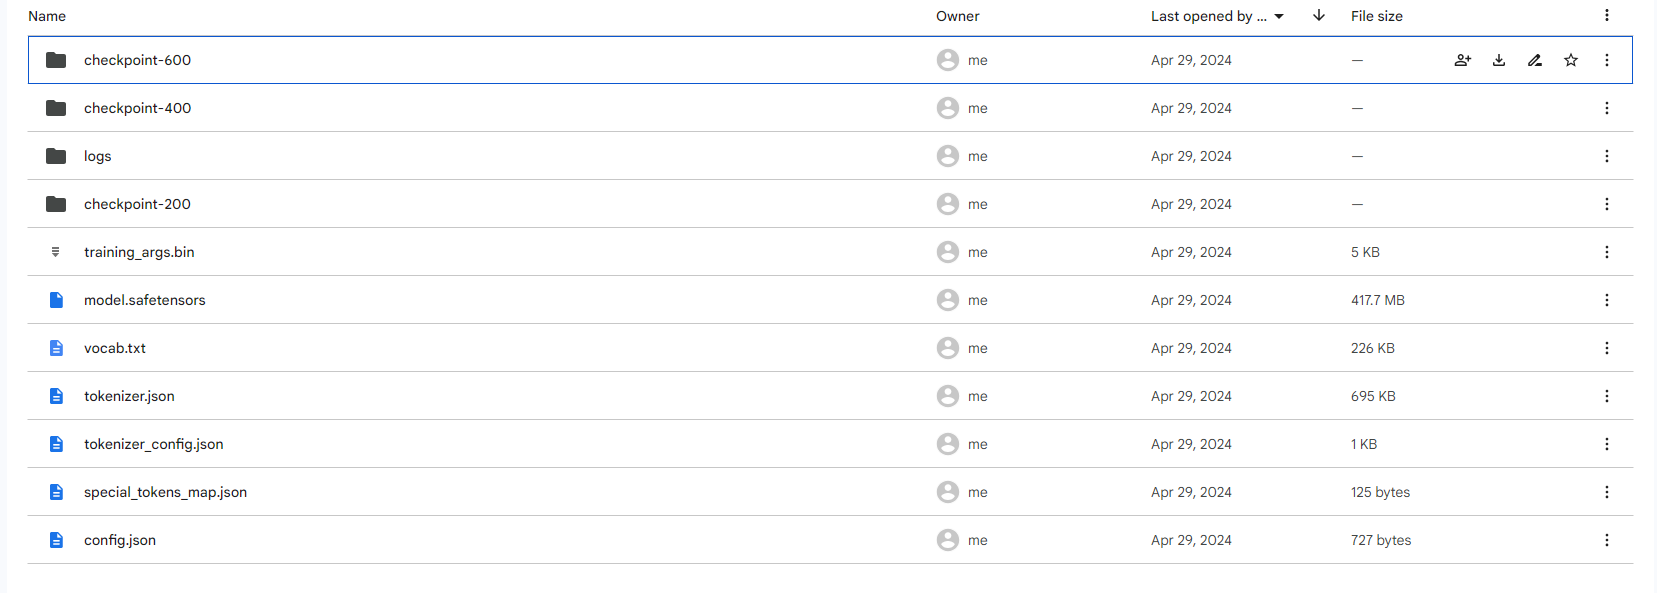